# 06 — Modeling Satellite + Tabular

## Baselines + Models

**DSRF + MCMIPF fusion with tabular, with MLflow tracking**

**Optuna (JournalStorage + lock)**

In [65]:
from pathlib import Path
import os, json, math, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
# from tensorflow.keras import mixed_precision

import mlflow
import mlflow.keras

In [66]:
mlflow.set_experiment("pg_industrial_satellite_fusion")
mlflow.keras.autolog(log_models=False)  

### Config

In [67]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# try:
#     policy = mixed_precision.Policy("mixed_float16")
#     mixed_precision.set_global_policy(policy)
#     print("Using mixed precision:", policy)
# except Exception as e:
#     print("Mixed precision not enabled:", e)

gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

# Rutas
ROOT = Path("..").resolve()
DATA_CLEAN = ROOT / "data" / "clean" / "base_dataset.csv"
GOES_DIR   = ROOT / "data" / "GOES_v2"

OUT_DIR = ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR = OUT_DIR / "artifacts_satellite"
ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figures" / "satellite"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Target y ventanas
TARGET_COL = "GHI"
FREQ = "10T"

# Ventana más corta para cuidar memoria: 4h de pasado
DEFAULT_INPUT_STEPS   = 24   # 24 * 10 min = 4h
DEFAULT_HORIZON_STEPS = 6    # 6 * 10 min = 1h adelante

PATIENCE = 6

# Tamaño de imagen reducido
IMG_SIZE = 32  # antes 64

# MLflow
MLFLOW_DIR = (OUT_DIR / "mlruns").resolve()
mlflow.set_tracking_uri("file://" + str(MLFLOW_DIR))
mlflow.set_experiment("pg_industrial_satellite_fusion")
print("MLflow tracking:", MLFLOW_DIR)

TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
MLflow tracking: /mnt/SOLARLAB/E_Ladino/Repo_2/solar-forecasting-colombia/outputs/mlruns


### Data

In [68]:
df = pd.read_csv(DATA_CLEAN, parse_dates=[0], index_col=0).sort_index()
df.index.name = "time"

# Features tabulares (las mismas del script tabular)
base_feats = [
    'Presion','TempAmb','WindSpeed','WindDirection',
    'hour_sin','hour_cos','DoY Sin','DoY Cos',
    'solar_zenith','solar_azimuth','solar_elevation',
    'TempAmb_roll1h_mean','TempAmb_roll6h_mean',
    'Presion_roll1h_mean','Presion_roll6h_mean',
    'WindSpeed_roll1h_mean','WindSpeed_roll6h_mean',
    'temp_pressure_ratio','wind_temp_interaction'
]
ghi_lags  = [c for c in ['GHI_lag1','GHI_lag3','GHI_lag6','GHI_lag12','GHI_lag36'] if c in df.columns]
ghi_rolls = [c for c in ['GHI_roll1h_mean','GHI_roll3h_mean','GHI_roll6h_mean','GHI_roll1h_max'] if c in df.columns]
feat_cols = [c for c in base_feats if c in df.columns] + ghi_lags + ghi_rolls
print(f"Total features used: {len(feat_cols)}")
print(feat_cols)

assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' no existe en el dataset"

# Split temporal
n = len(df); i_tr = int(0.7*n); i_va = int(0.85*n)
df_train, df_val, df_test = df.iloc[:i_tr], df.iloc[i_tr:i_va], df.iloc[i_va:]

# Escalado
X_scaler = StandardScaler(); y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(df_train[feat_cols].values)
X_val   = X_scaler.transform(df_val[feat_cols].values)
X_test  = X_scaler.transform(df_test[feat_cols].values)

y_train = y_scaler.fit_transform(df_train[[TARGET_COL]].values).ravel()
y_val   = y_scaler.transform(df_val[[TARGET_COL]].values).ravel()
y_test  = y_scaler.transform(df_test[[TARGET_COL]].values).ravel()

# Imputación robusta
imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X_train)
X_val   = imp.transform(X_val)
X_test  = imp.transform(X_test)

for name, arr in [("X_train",X_train),("X_val",X_val),("X_test",X_test),
                  ("y_train",y_train),("y_val",y_val),("y_test",y_test)]:
    assert np.isfinite(arr).all(), f"{name} tiene NaN/Inf"

# índices para alinear con imágenes
time_index = df.index
time_train, time_val, time_test = time_index[:i_tr], time_index[i_tr:i_va], time_index[i_va:]
print("N train/val/test:", len(time_train), len(time_val), len(time_test))

Total features used: 28
['Presion', 'TempAmb', 'WindSpeed', 'WindDirection', 'hour_sin', 'hour_cos', 'DoY Sin', 'DoY Cos', 'solar_zenith', 'solar_azimuth', 'solar_elevation', 'TempAmb_roll1h_mean', 'TempAmb_roll6h_mean', 'Presion_roll1h_mean', 'Presion_roll6h_mean', 'WindSpeed_roll1h_mean', 'WindSpeed_roll6h_mean', 'temp_pressure_ratio', 'wind_temp_interaction', 'GHI_lag1', 'GHI_lag3', 'GHI_lag6', 'GHI_lag12', 'GHI_lag36', 'GHI_roll1h_mean', 'GHI_roll3h_mean', 'GHI_roll6h_mean', 'GHI_roll1h_max']
N train/val/test: 75020 16076 16076


### Helpers

In [69]:
def metrics_from_scaled(pred_scaled, true_scaled, y_scaler):
    """
    Calcula métricas en espacio original, ignorando NaN/Inf.
    Si no hay ningún par finito, devuelve métricas = NaN.
    """
    # Inversa de escalado
    p = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    t = y_scaler.inverse_transform(true_scaled.reshape(-1, 1)).ravel()

    # Filtro de valores finitos
    mask = np.isfinite(p) & np.isfinite(t)

    if mask.sum() == 0:
        print("[metrics_from_scaled] ERROR: todas las predicciones o etiquetas son NaN/Inf.")
        metrics = {k: float("nan") for k in ["MAE","RMSE","MAPE","sMAPE","R2"]}
        return metrics, (t, p)

    if mask.sum() < len(p):
        print(f"[metrics_from_scaled] WARNING: filtrados {len(p) - mask.sum()} puntos no finitos.")

    p = p[mask]
    t = t[mask]

    mae = mean_absolute_error(t, p)
    rmse = float(np.sqrt(mean_squared_error(t, p)))
    mape = float(np.mean(np.abs(t - p) / (np.abs(t) + 1e-6)) * 100)
    smape = float(100 * np.mean(2*np.abs(p - t) / (np.abs(t) + np.abs(p) + 1e-6)))
    r2 = float(r2_score(t, p))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "sMAPE": smape, "R2": r2}, (t, p)


def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))


def build_seq_arrays_tabular(X_2d, y_1d, L, horizon, stride=1):
    """
    Sólo tabular: devuelve secuencias (N', L, F) y targets (N',)
    stride: salta ventanas para controlar tamaño (ej. stride=3 -> ~1/3 de muestras)
    """
    N, F = X_2d.shape
    outX, outy = [], []
    last = N - L - horizon + 1
    if last <= 0:
        return np.zeros((0, L, F), dtype="float32"), np.zeros((0,), dtype="float32")
    for i in range(0, last, stride):
        block = X_2d[i:i+L]
        outX.append(block)
        outy.append(y_1d[i + L + horizon - 1])
    return np.asarray(outX, dtype="float32"), np.asarray(outy, dtype="float32")


def build_seq_arrays_fusion(X_2d, y_1d, imgs_4d, L, horizon, stride=1):
    """
    Secuencias sincronizadas tabular + imágenes (DSRF).

    X_2d   : (N, F_tab)
    y_1d   : (N,)
    imgs_4d: (N, H, W, C)
    L      : input_steps
    horizon: horizon_steps
    stride : salta ventanas para controlar tamaño

    Devuelve:
      X_tab_seq: (N', L, F_tab)
      X_img_seq: (N', L, H, W, C)
      y_seq    : (N',)
    """
    N, F = X_2d.shape
    assert imgs_4d.shape[0] == N, "imgs_4d y X_2d no alinean en N"
    H, W, C = imgs_4d.shape[1:]
    X_tab_seq, X_img_seq, y_seq = [], [], []
    last = N - L - horizon + 1
    if last <= 0:
        return (np.zeros((0, L, F), dtype="float32"),
                np.zeros((0, L, H, W, C), dtype="float32"),
                np.zeros((0,), dtype="float32"))
    for i in range(0, last, stride):
        block_tab = X_2d[i:i+L]
        block_img = imgs_4d[i:i+L]
        X_tab_seq.append(block_tab)
        X_img_seq.append(block_img)
        y_seq.append(y_1d[i + L + horizon - 1])
    return (np.asarray(X_tab_seq, dtype="float32"),
            np.asarray(X_img_seq, dtype="float32"),
            np.asarray(y_seq,     dtype="float32"))


def build_seq_arrays_images(y_1d, imgs_4d, L, horizon, stride=1):
    """
    Sólo imágenes: secuencias (N', L, H, W, C) y targets (N',)
    Evita crear secuencias tabulares dummy.
    """
    N = imgs_4d.shape[0]
    H, W, C = imgs_4d.shape[1:]
    X_img_seq, y_seq = [], []
    last = N - L - horizon + 1
    if last <= 0:
        return (np.zeros((0, L, H, W, C), dtype="float32"),
                np.zeros((0,), dtype="float32"))
    for i in range(0, last, stride):
        block_img = imgs_4d[i:i+L]
        X_img_seq.append(block_img)
        y_seq.append(y_1d[i + L + horizon - 1])
    return (np.asarray(X_img_seq, dtype="float32"),
            np.asarray(y_seq,     dtype="float32"))


### Satellite

In [70]:
DSRF_DIR   = GOES_DIR / "DSRF"
MCMIPF_DIR = GOES_DIR / "MCMIPF"

In [71]:
def build_dsrf_by_hour(time_index, target_size=IMG_SIZE):
    """
    Construye dsrf_all: (N, H, W, 1) con H=W=target_size (por defecto 32)
    """
    hours = time_index.floor("H")
    unique_hours = sorted(hours.unique())

    hour_to_img = {}
    missing_hours = 0

    assert 256 % target_size == 0
    step = 256 // target_size

    for h in unique_hours:
        key = h.strftime("%Y%m%d_%H")
        year = key[:4]
        month = key[4:6]
        fname = f"{key}_DSRF.npz"
        path = DSRF_DIR / year / month / fname
        if not path.exists():
            # Falta de archivo -> imagen neutra (0)
            hour_to_img[key] = np.zeros((target_size, target_size, 1), dtype="float32")
            missing_hours += 1
            continue

        data = np.load(path)
        arr = data[list(data.files)[0]].astype("float32")  # (1,256,256)
        img = arr[0][::step, ::step]                       # 256 -> target_size

        # ***** PARCHE CLAVE: matar NaNs / Inf *****
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)

        hour_to_img[key] = img[..., None]                  # (H,W,1)

    print(f"DSRF: horas únicas en df      = {len(unique_hours)}")
    print(f"DSRF: horas sin archivo NOAA  = {missing_hours}")

    imgs = []
    for ts in time_index:
        key = ts.strftime("%Y%m%d_%H")
        imgs.append(hour_to_img[key])
    dsrf_all = np.stack(imgs, axis=0).astype("float32")
    return dsrf_all



In [72]:
print("→ Cargando DSRF completo (por hora, downsampleado a 32x32)...")
dsrf_all = build_dsrf_by_hour(time_index, target_size=32)
print("DSRF_all:", dsrf_all.shape)

# Limpieza NaNs/Inf
print("NaNs en dsrf_all antes de limpiar:", np.isnan(dsrf_all).sum())
dsrf_all = np.nan_to_num(dsrf_all, nan=0.0, posinf=0.0, neginf=0.0)
print("NaNs en dsrf_all después de limpiar:", np.isnan(dsrf_all).sum())

# Normalización global (media 0, var ≈ 1)
dsrf_mean = dsrf_all.mean()
dsrf_std  = dsrf_all.std() + 1e-6
print(f"DSRF mean={dsrf_mean:.3f}, std={dsrf_std:.3f}")
dsrf_all = (dsrf_all - dsrf_mean) / dsrf_std

→ Cargando DSRF completo (por hora, downsampleado a 32x32)...


DSRF: horas únicas en df      = 17862
DSRF: horas sin archivo NOAA  = 237
DSRF_all: (107172, 32, 32, 1)
NaNs en dsrf_all antes de limpiar: 0
NaNs en dsrf_all después de limpiar: 0
DSRF mean=173.884, std=273.990


In [73]:
dsrf_train, dsrf_val, dsrf_test = dsrf_all[:i_tr], dsrf_all[i_tr:i_va], dsrf_all[i_va:]

for name, arr in [("dsrf_train",dsrf_train),("dsrf_val",dsrf_val),("dsrf_test",dsrf_test)]:
    assert np.isfinite(arr).all(), f"{name} tiene NaN/Inf después de limpiar"

print("Tensores DSRF listos.")

Tensores DSRF listos.


### Models

#### 1) ConvLSTM con DSRF (solo satélite)

In [74]:
def build_convlstm_dsrf(L, H=32, W=32, C=1,
                        filters1=16, filters2=32, k=3,
                        dense_units=64, dropout_rate=0.2):
    """
    ConvLSTM encoder-forecast simple y estable.
    Input: (L, H, W, C)  Normalizado por canal.
    Output: 1 escalar (GHI)
    """
    inp = layers.Input(shape=(L, H, W, C))

    # Primera capa ConvLSTM: devuelve secuencias
    x = layers.ConvLSTM2D(
        filters=filters1,
        kernel_size=(k, k),
        padding="same",
        return_sequences=True,
        activation="tanh",
        dropout=dropout_rate,           # dropout en inputs
        recurrent_dropout=dropout_rate  # dropout en estado recurrente
    )(inp)
    x = layers.BatchNormalization()(x)

    # Segunda capa ConvLSTM: solo última salida
    x = layers.ConvLSTM2D(
        filters=filters2,
        kernel_size=(k, k),
        padding="same",
        return_sequences=False,
        activation="tanh",
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    )(x)
    x = layers.BatchNormalization()(x)

    # Pooling espacial + MLP final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)   # aquí sí, tensor 2D (batch, units)

    out = layers.Dense(1, dtype="float32")(x)

    model = models.Model(inp, out, name="ConvLSTM_DSRF_lite")
    return model


#### 2) Fusión DSRF + tabular (encoder CNN + LSTM tabular)

In [75]:
def build_dsrf_tabular_fusion(L, n_feat_tab, H=32, W=32, C=1,
                              img_emb_dim=64, tab_units=64, dense_units=64,
                              dropout_rate=0.2):
    """
    Fusión:
      - rama imágenes: TimeDistributed(CNN pequeña + BatchNorm) -> LSTM imagen
      - rama tabular: LSTM
      - concat -> Dense -> 1
    """
    # Rama imágenes
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")

    def make_cnn_block():
        model = models.Sequential(name="cnn_dsrf_frame")
        model.add(layers.Conv2D(16, (3,3), padding="same", activation="relu", input_shape=(H,W,C)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(img_emb_dim, activation="relu"))
        return model

    cnn_block = make_cnn_block()
    x_img = layers.TimeDistributed(cnn_block, name="td_cnn")(inp_img)
    x_img = layers.LSTM(64, activation="tanh", name="lstm_img")(x_img)

    # Rama tabular
    inp_tab = layers.Input(shape=(L, n_feat_tab), name="tab_seq")
    x_tab = layers.LSTM(tab_units, activation="tanh", name="lstm_tab")(inp_tab)

    # Fusión
    x = layers.Concatenate(name="fusion")([x_img, x_tab])
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)

    model = models.Model([inp_img, inp_tab], out, name="DSRF_Tabular_Fusion_lite")
    return model

#### Plots

In [76]:
def plot_sample_series(y_true, y_pred, title, n=1000, fname=None):
    n = min(n, len(y_true))
    plt.figure(figsize=(11,3.8))
    plt.plot(y_true[:n], label="Real", lw=1.5)
    plt.plot(y_pred[:n], label="Pred", lw=1.2, alpha=0.9)
    plt.title(title); plt.xlabel("Time steps (10-min)")
    plt.ylabel("GHI (W/m²)")
    plt.legend(frameon=False); plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, dpi=140)
    plt.show()

### Sequences + Training + Mlflow

In [77]:
# X_dummy_tab = np.zeros_like(X_train)
# Xtr_tab_seq, Xtr_img_seq, ytr_seq = build_seq_arrays_fusion(
#     X_2d=X_dummy_tab,
#     y_1d=y_train,
#     imgs_4d=dsrf_train,
#     L=DEFAULT_INPUT_STEPS,
#     horizon=DEFAULT_HORIZON_STEPS,
#     stride=3,
# )
# print("Shapes sanity check:")
# print("Xtr_tab_seq:", Xtr_tab_seq.shape)
# print("Xtr_img_seq:", Xtr_img_seq.shape)
# print("ytr_seq    :", ytr_seq.shape)

#### ConvLSTM con DSRF (solo imágenes)

In [78]:

def train_convlstm_dsrf(input_steps=DEFAULT_INPUT_STEPS,
                        horizon_steps=DEFAULT_HORIZON_STEPS,
                        lr=3e-4,
                        batch_size=4,
                        epochs=25,
                        stride=4):
    """
    Modelo sólo imágenes (DSRF) con training más estable.
    """

    # Secuencias de imágenes (sin tabular)
    Xtr_img_seq, ytr_seq = build_seq_arrays_images(
        y_1d=y_train,
        imgs_4d=dsrf_train,
        L=input_steps,
        horizon=horizon_steps,
        stride=stride,
    )
    Xva_img_seq, yva_seq = build_seq_arrays_images(
        y_1d=y_val,
        imgs_4d=dsrf_val,
        L=input_steps,
        horizon=horizon_steps,
        stride=stride,
    )

    print("ConvLSTM DSRF shapes:")
    print("Xtr_img_seq:", Xtr_img_seq.shape)
    print("ytr_seq    :", ytr_seq.shape)

    H, W, C = Xtr_img_seq.shape[2:]
    model = build_convlstm_dsrf(L=input_steps, H=H, W=W, C=C)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        clipnorm=1.0
    )
    model.compile(optimizer=optimizer, loss="mse")

    ckpt = (ART_DIR / "best_convlstm_dsrf.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE,
            restore_best_weights=True, verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=str(ckpt), monitor="val_loss",
            save_best_only=True, save_weights_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5,
            patience=3, min_lr=1e-5, verbose=1
        )
    ]

    with mlflow.start_run(run_name="ConvLSTM_DSRF_lite"):
        mlflow.log_param("input_steps",   input_steps)
        mlflow.log_param("horizon_steps", horizon_steps)
        mlflow.log_param("lr",           lr)
        mlflow.log_param("batch_size",   batch_size)
        mlflow.log_param("epochs",       epochs)
        mlflow.log_param("stride",       stride)

        hist = model.fit(
            Xtr_img_seq, ytr_seq,
            validation_data=(Xva_img_seq, yva_seq),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=cbs,
            shuffle=True,
        )

        # Test
        Xte_img_seq, yte_seq = build_seq_arrays_images(
            y_1d=y_test,
            imgs_4d=dsrf_test,
            L=input_steps,
            horizon=horizon_steps,
            stride=stride,
        )
        yhat_test_scaled = model.predict(Xte_img_seq, verbose=0).squeeze()

        print("NaNs en yhat_test_scaled:", np.isnan(yhat_test_scaled).sum(), "/", yhat_test_scaled.size)
        print("NaNs en yte_seq:", np.isnan(yte_seq).sum(), "/", yte_seq.size)

        metrics, (t_o, p_o) = metrics_from_scaled(yhat_test_scaled, yte_seq, y_scaler)
        for k, v in metrics.items():
            mlflow.log_metric(f"test_{k}", float(v))

        # ---- MLflow: firma + input_example para quitar warnings ----
        from mlflow.models import infer_signature
        sig = infer_signature(Xte_img_seq[:32], model.predict(Xte_img_seq[:32]))
        input_example = Xte_img_seq[:1]

        mlflow.keras.log_model(
            model,
            artifact_path="ConvLSTM_DSRF_lite",
        )

        print("ConvLSTM DSRF test metrics:", metrics)

    return model, metrics, (t_o, p_o)


#### Fusión DSRF + Tabular

In [79]:
def train_dsrf_tabular_fusion(input_steps=DEFAULT_INPUT_STEPS,
                              horizon_steps=DEFAULT_HORIZON_STEPS,
                              lr=5e-4,
                              batch_size=8,
                              epochs=25,
                              stride=3):
    """
    Modelo que integra:
      - secuencias tabulares (L, F)
      - secuencias de imágenes DSRF (L, H, W, 1)
    """
    Xtr_tab_seq, Xtr_img_seq, ytr_seq = build_seq_arrays_fusion(
        X_2d=X_train, y_1d=y_train,
        imgs_4d=dsrf_train, L=input_steps, horizon=horizon_steps,
        stride=stride
    )
    Xva_tab_seq, Xva_img_seq, yva_seq = build_seq_arrays_fusion(
        X_2d=X_val, y_1d=y_val,
        imgs_4d=dsrf_val, L=input_steps, horizon=horizon_steps,
        stride=stride
    )

    print("Fusion DSRF+Tabular shapes:")
    print("Xtr_tab_seq:", Xtr_tab_seq.shape)
    print("Xtr_img_seq:", Xtr_img_seq.shape)
    print("ytr_seq    :", ytr_seq.shape)

    L = input_steps
    n_feat_tab = Xtr_tab_seq.shape[2]
    H, W, C = Xtr_img_seq.shape[2:]

    model = build_dsrf_tabular_fusion(
        L=L, n_feat_tab=n_feat_tab,
        H=H, W=W, C=C,
        img_emb_dim=64,
        tab_units=64,
        dense_units=64,
        dropout_rate=0.2,
    )

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        clipnorm=1.0
    )
    model.compile(optimizer=optimizer, loss="mse")

    ckpt = (ART_DIR / "best_dsrf_tabular_fusion.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE+2,
            restore_best_weights=True, verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=str(ckpt), monitor="val_loss",
            save_best_only=True, save_weights_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5,
            patience=3, min_lr=1e-5, verbose=1
        )
    ]

    with mlflow.start_run(run_name="DSRF_Tabular_Fusion_lite"):
        mlflow.log_param("input_steps",   input_steps)
        mlflow.log_param("horizon_steps", horizon_steps)
        mlflow.log_param("lr",           lr)
        mlflow.log_param("batch_size",   batch_size)
        mlflow.log_param("epochs",       epochs)
        mlflow.log_param("stride",       stride)
        mlflow.log_param("img_H",        H)
        mlflow.log_param("img_W",        W)
        mlflow.log_param("img_C",        C)
        mlflow.log_param("n_feat_tab",   n_feat_tab)

        hist = model.fit(
            {"img_seq": Xtr_img_seq, "tab_seq": Xtr_tab_seq},
            ytr_seq,
            validation_data=(
                {"img_seq": Xva_img_seq, "tab_seq": Xva_tab_seq},
                yva_seq
            ),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=cbs,
            shuffle=True,
        )

        # Test
        Xte_tab_seq, Xte_img_seq, yte_seq = build_seq_arrays_fusion(
            X_2d=X_test, y_1d=y_test,
            imgs_4d=dsrf_test,
            L=input_steps, horizon=horizon_steps,
            stride=stride
        )
        yhat_test_scaled = model.predict(
            {"img_seq": Xte_img_seq, "tab_seq": Xte_tab_seq},
            verbose=0
        ).squeeze()

        metrics, (t_o, p_o) = metrics_from_scaled(yhat_test_scaled, yte_seq, y_scaler)
        for k, v in metrics.items():
            mlflow.log_metric(f"test_{k}", float(v))

        # ---- MLflow: firma + input_example ----
        from mlflow.models import infer_signature
        example_in = {"img_seq": Xte_img_seq[:1], "tab_seq": Xte_tab_seq[:1]}
        sig = infer_signature(example_in, model.predict(example_in))

        mlflow.keras.log_model(
            model,
            artifact_path="DSRF_Tabular_Fusion_lite",
        )


        print("DSRF + Tabular fusion test metrics:", metrics)

    return model, metrics, (t_o, p_o)


## Execution

### 1) ConvLSTM sólo DSRF

ConvLSTM DSRF shapes:
Xtr_img_seq: (18748, 24, 32, 32, 1)
ytr_seq    : (18748,)


Epoch 1/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 118s 24ms/step - loss: 0.4224 - val_loss: 0.1676 - learning_rate: 5.0000e-04
Epoch 2/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 104s 22ms/step - loss: 0.3514 - val_loss: 0.1832 - learning_rate: 5.0000e-04
Epoch 3/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 104s 22ms/step - loss: 0.3383 - val_loss: 0.1790 - learning_rate: 5.0000e-04
Epoch 4/20
4686/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3267
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - loss: 0.3306 - val_loss: 0.1699 - learning_rate: 5.0000e-04
Epoch 5/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - loss: 0.3176 - val_loss: 0.1653 - learning_rate: 2.5000e-04
Epoch 6/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - loss: 0.3160 - val_loss: 0.1684 - learning_rate: 2.5000e-04
Epoch 7/20
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - loss: 0.3115 - val_loss: 0.1599 - learning_rate: 2.5000e-04
Epoch 8/20
4687/4687 ━━━━━━━━━━━

2025/11/22 18:53:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 18:54:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/22 18:54:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ConvLSTM DSRF test metrics: {'MAE': 58.79022216796875, 'RMSE': 106.39125261417172, 'MAPE': 93922784.0, 'sMAPE': 111.80443572998047, 'R2': 0.892066478729248}
ConvLSTM DSRF metrics: {'MAE': 58.79022216796875, 'RMSE': 106.39125261417172, 'MAPE': 93922784.0, 'sMAPE': 111.80443572998047, 'R2': 0.892066478729248}


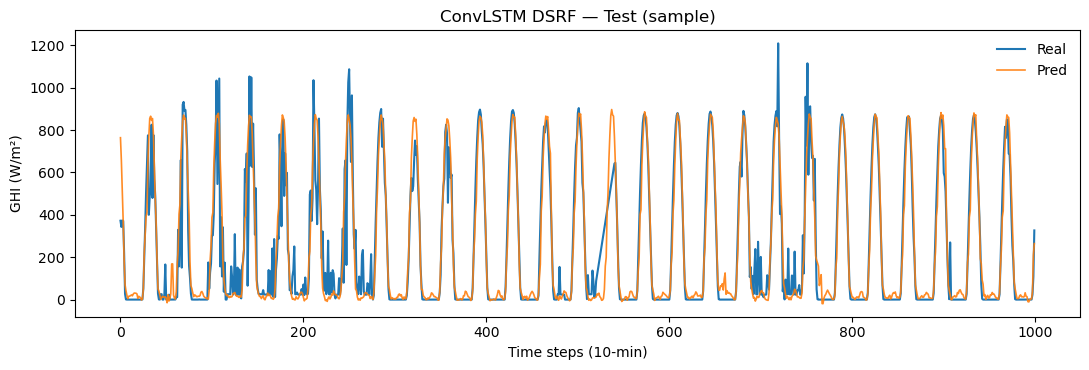

In [80]:
conv_model, conv_metrics, (ytrue_conv, ypred_conv) = train_convlstm_dsrf(
    input_steps=DEFAULT_INPUT_STEPS,
    horizon_steps=DEFAULT_HORIZON_STEPS,
    lr=5e-4,
    batch_size=4,
    epochs=20,
    stride=4,
)

print("ConvLSTM DSRF metrics:", conv_metrics)

plot_sample_series(
    ytrue_conv, ypred_conv,
    "ConvLSTM DSRF — Test (sample)",
    fname=FIG_DIR / "convlstm_dsrf_sample.png")

### 2) Fusion DSRF + Tabular

Fusion DSRF+Tabular shapes:
Xtr_tab_seq: (18748, 24, 28)
Xtr_img_seq: (18748, 24, 32, 32, 1)
ytr_seq    : (18748,)


2025/11/22 18:54:45 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'dict'>. Dataset logging skipped.


Epoch 1/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - loss: 0.1235 - val_loss: 0.1100 - learning_rate: 5.0000e-04
Epoch 2/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.1020 - val_loss: 0.1037 - learning_rate: 5.0000e-04
Epoch 3/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.0975 - val_loss: 0.1024 - learning_rate: 5.0000e-04
Epoch 4/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step - loss: 0.0958 - val_loss: 0.1021 - learning_rate: 5.0000e-04
Epoch 5/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 68s 15ms/step - loss: 0.0929 - val_loss: 0.0996 - learning_rate: 5.0000e-04
Epoch 6/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - loss: 0.0917 - val_loss: 0.0996 - learning_rate: 5.0000e-04
Epoch 7/25
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.0894 - val_loss: 0.1022 - learning_rate: 5.0000e-04
Epoch 8/25
4686/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0889
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4687/4687 ━━━━━━━━━━━━━━━━━━

2025/11/22 19:13:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 19:13:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/22 19:13:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DSRF + Tabular fusion test metrics: {'MAE': 43.79816818237305, 'RMSE': 86.38894492171727, 'MAPE': 29354266.0, 'sMAPE': 109.31163024902344, 'R2': 0.928835928440094}
DSRF + Tabular fusion metrics: {'MAE': 43.79816818237305, 'RMSE': 86.38894492171727, 'MAPE': 29354266.0, 'sMAPE': 109.31163024902344, 'R2': 0.928835928440094}


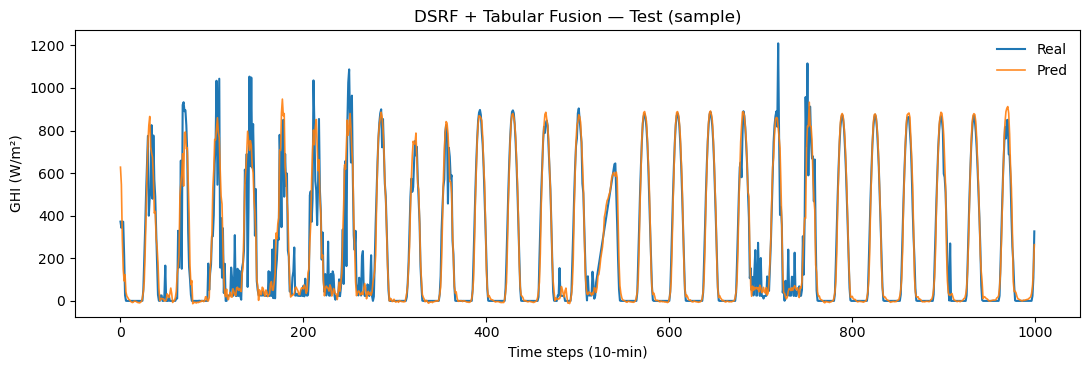

In [81]:
fusion_model, fusion_metrics, (ytrue_fus, ypred_fus) = train_dsrf_tabular_fusion(
    input_steps=DEFAULT_INPUT_STEPS,
    horizon_steps=DEFAULT_HORIZON_STEPS,
    lr=5e-4,
    batch_size=4,
    epochs=25,
    stride=4,
)
print("DSRF + Tabular fusion metrics:", fusion_metrics)

plot_sample_series(
    ytrue_fus, ypred_fus,
    "DSRF + Tabular Fusion — Test (sample)",
    fname=FIG_DIR / "dsrf_tabular_fusion_sample.png"
)

In [82]:
res = pd.DataFrame({
    "ConvLSTM_DSRF_lite": conv_metrics,
    "DSRF_Tabular_Fusion_lite": fusion_metrics,
}).T
print(res.round(3).to_string())

                             MAE     RMSE        MAPE    sMAPE     R2
ConvLSTM_DSRF_lite        58.790  106.391  93922784.0  111.804  0.892
DSRF_Tabular_Fusion_lite  43.798   86.389  29354266.0  109.312  0.929


### Extra plots

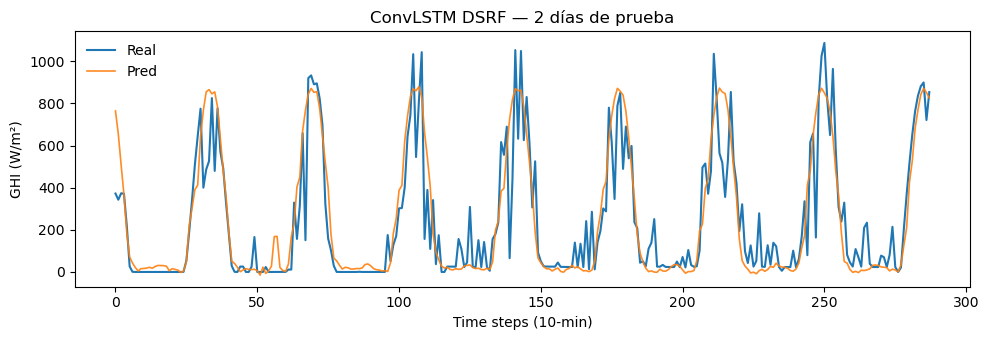

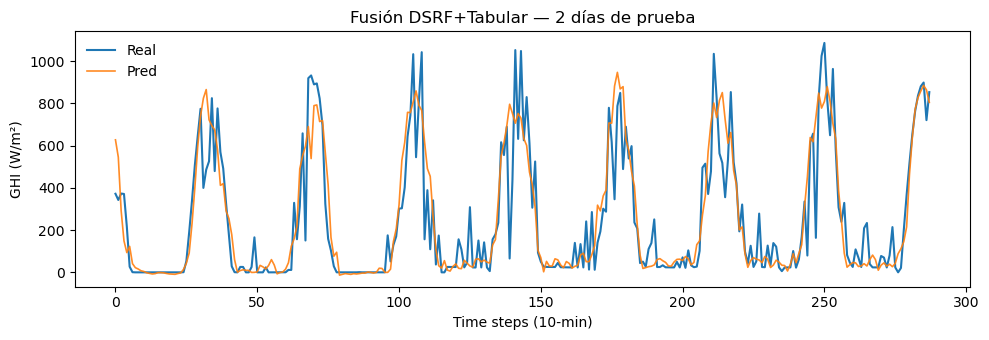

In [83]:
def plot_sample_series_zoom(y_true, y_pred, title, start=0, n=288, fname=None):
    end = min(start + n, len(y_true))
    plt.figure(figsize=(10, 3.5))
    plt.plot(range(end-start), y_true[start:end], label="Real", lw=1.5)
    plt.plot(range(end-start), y_pred[start:end], label="Pred", lw=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Time steps (10-min)")
    plt.ylabel("GHI (W/m²)")
    plt.legend(frameon=False)
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, dpi=140)
    plt.show()


plot_sample_series_zoom(ytrue_conv, ypred_conv,
                        "ConvLSTM DSRF — 2 días de prueba",
                        start=0, n=288,
                        fname=FIG_DIR / "convlstm_dsrf_2days.png")

plot_sample_series_zoom(ytrue_fus, ypred_fus,
                        "Fusión DSRF+Tabular — 2 días de prueba",
                        start=0, n=288,
                        fname=FIG_DIR / "fusion_dsrf_tab_2days.png")


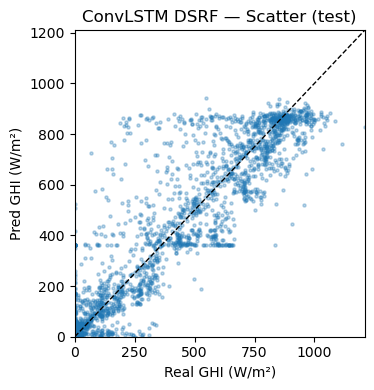

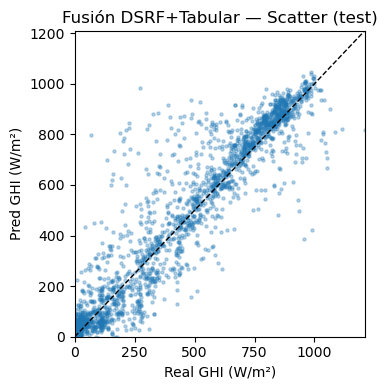

In [84]:
def plot_scatter_true_pred(y_true, y_pred, title, fname=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(y_true, y_pred, s=5, alpha=0.3)
    lims = [0, max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("Real GHI (W/m²)")
    plt.ylabel("Pred GHI (W/m²)")
    plt.title(title)
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, dpi=140)
    plt.show()

plot_scatter_true_pred(
    ytrue_conv, ypred_conv,
    "ConvLSTM DSRF — Scatter (test)",
    fname=FIG_DIR / "scatter_convlstm_dsrf.png"
)

plot_scatter_true_pred(
    ytrue_fus, ypred_fus,
    "Fusión DSRF+Tabular — Scatter (test)",
    fname=FIG_DIR / "scatter_fusion_dsrf_tab.png"
)


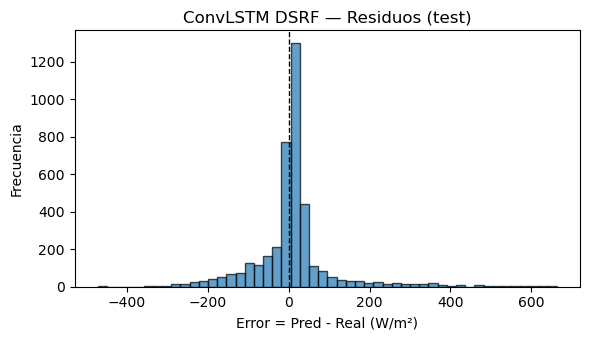

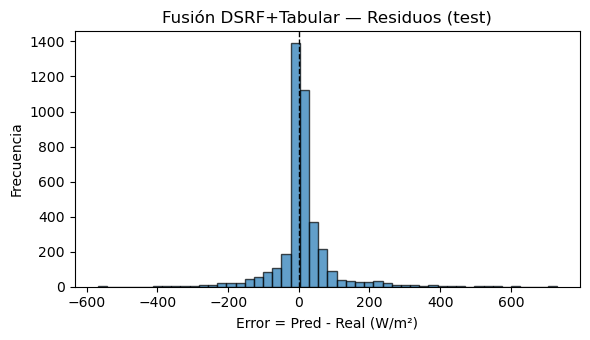

In [85]:
def plot_residual_hist(y_true, y_pred, title, bins=50, fname=None):
    resid = y_pred - y_true
    plt.figure(figsize=(6, 3.5))
    plt.hist(resid, bins=bins, edgecolor='k', alpha=0.7)
    plt.axvline(0, color='k', linestyle='--', lw=1)
    plt.xlabel("Error = Pred - Real (W/m²)")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, dpi=140)
    plt.show()

plot_residual_hist(
    ytrue_conv, ypred_conv,
    "ConvLSTM DSRF — Residuos (test)",
    fname=FIG_DIR / "resid_convlstm_dsrf.png"
)

plot_residual_hist(
    ytrue_fus, ypred_fus,
    "Fusión DSRF+Tabular — Residuos (test)",
    fname=FIG_DIR / "resid_fusion_dsrf_tab.png"
)


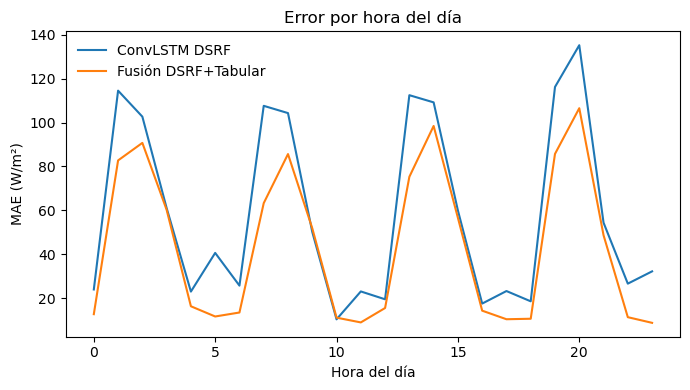

In [86]:
def hourly_mae(y_true, y_pred, time_index):
    df = pd.DataFrame({
        "true": y_true,
        "pred": y_pred,
        "hour": time_index.hour[:len(y_true)]
    })
    df["err"] = np.abs(df["true"] - df["pred"])
    return df.groupby("hour")["err"].mean()

mae_conv_hour = hourly_mae(ytrue_conv, ypred_conv, time_test)
mae_fus_hour  = hourly_mae(ytrue_fus, ypred_fus, time_test)

plt.figure(figsize=(7,4))
plt.plot(mae_conv_hour, label="ConvLSTM DSRF")
plt.plot(mae_fus_hour, label="Fusión DSRF+Tabular")
plt.xlabel("Hora del día")
plt.ylabel("MAE (W/m²)")
plt.title("Error por hora del día")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


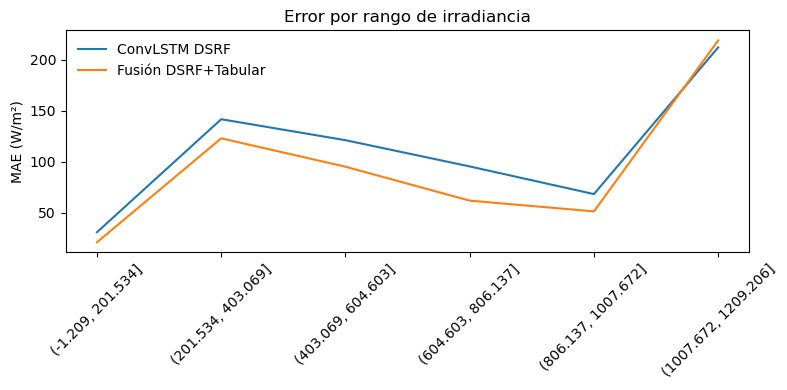

In [87]:
def mae_by_ghi(y_true, y_pred, bins=6):
    df = pd.DataFrame({"true": y_true, "pred": y_pred})
    df["bin"] = pd.cut(df["true"], bins=bins)
    df["err"] = np.abs(df["true"] - df["pred"])
    return df.groupby("bin")["err"].mean()

mae_conv_bin = mae_by_ghi(ytrue_conv, ypred_conv)
mae_fus_bin  = mae_by_ghi(ytrue_fus, ypred_fus)

plt.figure(figsize=(8,4))
plt.plot(mae_conv_bin.values, label="ConvLSTM DSRF")
plt.plot(mae_fus_bin.values, label="Fusión DSRF+Tabular")
plt.xticks(range(len(mae_conv_bin)), mae_conv_bin.index, rotation=45)
plt.ylabel("MAE (W/m²)")
plt.title("Error por rango de irradiancia")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


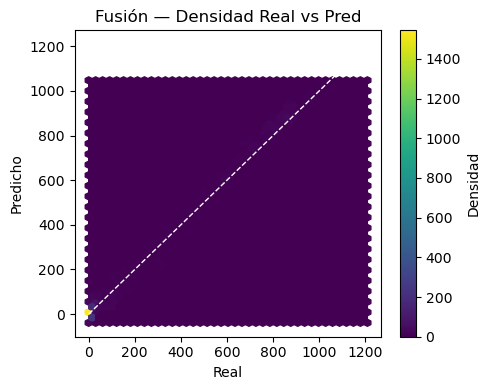

In [88]:
plt.figure(figsize=(5,4))
plt.hexbin(ytrue_fus, ypred_fus, gridsize=40, cmap='viridis')
lims = [0, max(ytrue_fus.max(), ypred_fus.max())]
plt.plot(lims, lims, 'w--', lw=1)
plt.colorbar(label="Densidad")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Fusión — Densidad Real vs Pred")
plt.tight_layout()
plt.show()